## Описание данных

### Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

### Данные которые нам известны:

*ID — уникальный идентификатор скважины;*

*f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);*

*product — объём запасов в скважине (тыс. баррелей).*

### Условия задачи:
Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).

При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.

Бюджет на разработку скважин в регионе — 10 млрд рублей.

При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

## Загрузка и подготовка данных

****Импортируем библиотеки которые нам понадобятся.****

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder,StandardScaler
from scipy import stats as st

In [2]:
pd.options.mode.chained_assignment = None

In [3]:
geo_0 = pd.read_csv('/datasets/geo_data_0.csv')
geo_1 = pd.read_csv('/datasets/geo_data_1.csv')
geo_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [4]:
def func(x):
    display(x.info())
    display(x.head(5))
    display(x.describe())
    print('Дубликаты:',x.duplicated().sum())
    print('Пропущеные значения:',x.isna().sum())
    return x

***Далее изучим наши признаки.***

In [5]:
display('Изучим первый регион')
display('------------------------------------------')
display(func(geo_0))

'Изучим первый регион'

'------------------------------------------'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


Дубликаты: 0
Пропущеные значения: id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
...,...,...,...,...,...
99995,DLsed,0.971957,0.370953,6.075346,110.744026
99996,QKivN,1.392429,-0.382606,1.273912,122.346843
99997,3rnvd,1.029585,0.018787,-1.348308,64.375443
99998,7kl59,0.998163,-0.528582,1.583869,74.040764


In [6]:
print('Изучим второй регион')
print('------------------------------------------')
display(func(geo_1))

Изучим второй регион
------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


Дубликаты: 0
Пропущеные значения: id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
...,...,...,...,...,...
99995,QywKC,9.535637,-6.878139,1.998296,53.906522
99996,ptvty,-10.160631,-12.558096,5.005581,137.945408
99997,09gWa,-7.378891,-3.084104,4.998651,137.945408
99998,rqwUm,0.665714,-6.152593,1.000146,30.132364


In [7]:
print('Изучим третий регион')
print('-------------------------------------------')
display(func(geo_2))

Изучим третий регион
-------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Дубликаты: 0
Пропущеные значения: id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
...,...,...,...,...,...
99995,4GxBu,-1.777037,1.125220,6.263374,172.327046
99996,YKFjq,-1.261523,-0.894828,2.524545,138.748846
99997,tKPY3,-1.199934,-2.957637,5.219411,157.080080
99998,nmxp2,-2.419896,2.417221,-5.548444,51.795253


***Вывод***
* Данных достаточно для выполнения задания.
* Нету пропущенных значений и дубликатов.
** f0,f1,f2 - на данном этапе можно заметить:
** минимальные показатели минусовые - догадываюсь,что очень убыточные.
** медианное значение не отрицательное только у первого региона.Остальные зачастую убыточные.Думаю при выборе правильное точке повысим существенно статистику.

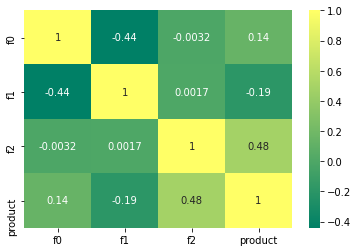

<Figure size 1152x432 with 0 Axes>

               f0        f1        f2   product
f0       1.000000 -0.440723 -0.003153  0.143536
f1      -0.440723  1.000000  0.001724 -0.192356
f2      -0.003153  0.001724  1.000000  0.483663
product  0.143536 -0.192356  0.483663  1.000000


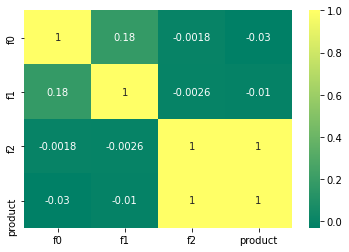

<Figure size 1152x432 with 0 Axes>

               f0        f1        f2   product
f0       1.000000  0.182287 -0.001777 -0.030491
f1       0.182287  1.000000 -0.002595 -0.010155
f2      -0.001777 -0.002595  1.000000  0.999397
product -0.030491 -0.010155  0.999397  1.000000


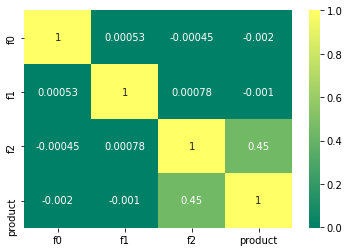

<Figure size 1152x432 with 0 Axes>

               f0        f1        f2   product
f0       1.000000  0.000528 -0.000448 -0.001987
f1       0.000528  1.000000  0.000779 -0.001012
f2      -0.000448  0.000779  1.000000  0.445871
product -0.001987 -0.001012  0.445871  1.000000


In [8]:
def fun(x):
    sns.heatmap(x.corr(),cmap='summer',annot=True)
    plt.figure(figsize=(16, 6))
    plt.show()
    return x.corr()
print(fun(geo_0))
print(fun(geo_1))
print(fun(geo_2))

**Вывод:**
* Заметил сильную зависимость признака f2 к объему скважины во всех регионах.
* Выделяется 2 регион там присутствует сильная зависимость f2 к объему скважин. Удалить данные будет не коректно потеряем большую часть,но будем иметь это ввиду.
* Так же я понимаю столбец id нам не как не понадобиться в данном иследовании.

## Обучение и проверка модели

### Geo 0

In [9]:
features = geo_0.drop(['product','id'],axis=1)
target = geo_0['product']

features_train, features_valid, target_train, target_valid = train_test_split(
features, target, test_size=0.25, random_state=12345)

numeric = ['f0', 'f1', 'f2']
scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])




model = LinearRegression().fit(features_train,target_train)
predictions_valid = pd.Series(model.predict(features_valid))

pv = predictions_valid.mean()
    
rmse = mean_squared_error(target_valid, predictions_valid,squared=False)
print("Среднее модели линейной регрессии на валидационной выборке:", pv)
print("RMSE модели линейной регрессии на валидационной выборке:", rmse)

Среднее модели линейной регрессии на валидационной выборке: 92.59256778438035
RMSE модели линейной регрессии на валидационной выборке: 37.5794217150813


### Geo 1

In [10]:
features_1 = geo_1.drop(['product','id'],axis=1)
target_1 = geo_1['product']

features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(
features_1, target_1, test_size=0.25, random_state=12345)

numeric_1 = ['f0', 'f1', 'f2']
scaler_1 = StandardScaler()
scaler_1.fit(features_train_1[numeric_1])

features_train_1[numeric_1] = scaler_1.transform(features_train_1[numeric_1])
features_valid_1[numeric_1] = scaler_1.transform(features_valid_1[numeric_1])




model_1 = LinearRegression().fit(features_train_1,target_train_1)
predictions_valid_1 = pd.Series(model_1.predict(features_valid_1))

pv_1 = predictions_valid_1.mean()

rmse_1 = mean_squared_error(target_valid_1, predictions_valid_1,squared=False)
print("Среднее модели линейной регрессии на валидационной выборке:", pv_1)
print("RMSE модели линейной регрессии на валидационной выборке:", rmse_1)

Среднее модели линейной регрессии на валидационной выборке: 68.728546895446
RMSE модели линейной регрессии на валидационной выборке: 0.893099286775617


### Geo 2

In [11]:
features_2 = geo_2.drop(['product','id'],axis=1)
target_2 = geo_2['product']

features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(
features_2, target_2, test_size=0.25, random_state=12345)

numeric_2 = ['f0', 'f1', 'f2']
scaler_2 = StandardScaler()
scaler_2.fit(features_train_2[numeric_2])

features_train_2[numeric_2] = scaler_2.transform(features_train_2[numeric_2])
features_valid_2[numeric_2] = scaler_2.transform(features_valid_2[numeric_2])




model_2 = LinearRegression().fit(features_train_2,target_train_2)
predictions_valid_2 = pd.Series(model_2.predict(features_valid_2))

pv_2 = predictions_valid_2.mean()
    
rmse_2 = mean_squared_error(target_valid_2, predictions_valid_2,squared=False)
print("Среднее модели линейной регрессии на валидационной выборке:", pv_2)
print("RMSE модели линейной регрессии на валидационной выборке:", rmse_2)

Среднее модели линейной регрессии на валидационной выборке: 94.96504596800489
RMSE модели линейной регрессии на валидационной выборке: 40.02970873393434


`Посмотрим на  данные которые у нас получились по предсказанию нашей модели по регионам:`

In [12]:
print('Предсказания 1 региона запаса сырья составил {:.2f}, а RMSE модели {:.2f}'.format(pv, rmse))
print('Предсказания 2 региона запаса сырья составил {:.2f}, а RMSE модели {:.2f}'.format(pv_1, rmse_1))
print('Предсказания 3 региона запаса сырья составил {:.2f}, а RMSE модели {:.2f}'.format(pv_2, rmse_2))

Предсказания 1 региона запаса сырья составил 92.59, а RMSE модели 37.58
Предсказания 2 региона запаса сырья составил 68.73, а RMSE модели 0.89
Предсказания 3 региона запаса сырья составил 94.97, а RMSE модели 40.03


`Так же посмотрим на данные реальные не предсказаные. И сравним нашу модель на сколько она отработала:`

In [13]:
print('1 регион средний запас сырья: {:.2f}'.format(target_valid.mean()))
print('2 регион средний запас сырья: {:.2f}'.format(target_valid_1.mean()))
print('3 регион средний запас сырья: {:.2f}'.format(target_valid_2.mean()))

1 регион средний запас сырья: 92.08
2 регион средний запас сырья: 68.72
3 регион средний запас сырья: 94.88


***Вывод***

* Наша модель отработала хорошо , результаты близки реальным!

* Выделяется второй регион. Скорее из-за сильной зависимости f2 к product.

* Лучше всего модель отработала во втором регионе. Первый и третий в целом одинаково отработала.

## Подготовка к расчёту прибыли

Бюджет на разработку скважин в регионе — 10 млрд рублей.

При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

**Константы ключевых значений**

In [14]:
EXPLORE_COUNT = 500 # количество точек для исследования
MINING_POINT = 200 # количество точек для разработки
BARREL_REVENUE = 0.45 # доход с 1 тыс бар в млн. руб
COAST_BOREHOLE = 10000 # бюджет на разработку скважин в регионе в млн. руб.
STATE = np.random.RandomState(12345)
BOOTSTRAP_SAMPLE = 1000
LOSS = 0.02 # максимальная вероятность убытков

**Расчёт скважины**

In [15]:
per_borehole = COAST_BOREHOLE / MINING_POINT# сколько потраченно на 1 скважину

# количество сырья потраченного на идеальную скважину
top_per = (per_borehole / BARREL_REVENUE)
print('Идеальный расклад на 1 скважину в тыс. бар.:',top_per)

Идеальный расклад на 1 скважину в тыс. бар.: 111.11111111111111


**Вывод**

* наша идеальный расклад на 1 скважину в тысячу барралей должен составлять не менее 111.1111тыс. за бар.
* это расклад при выборе 200 точек

вычеслим из топ 200 скважин дохододность по регионам.

**Певый регион**

In [16]:
pred_geo_0 = predictions_valid.sort_values(ascending=False).head(200) # выбирем 200 скважин
target_geo_0 = target_valid.reset_index(drop=True)[pred_geo_0.index]
geo_0_income = (target_geo_0.sum() * BARREL_REVENUE) - COAST_BOREHOLE # доход в млн. рублей с 200 скважин
print('Доход с 1 региона составляет:',geo_0_income)

Доход с 1 региона составляет: 3320.8260431398503


**Второй регион**

In [17]:
pred_geo_1 = predictions_valid_1.sort_values(ascending=False).head(200) # выбирем 200 скважин
target_geo_1= target_valid_1.reset_index(drop=True)[pred_geo_1.index]
geo_1_income = (target_geo_1.sum() * BARREL_REVENUE) - COAST_BOREHOLE # доход в млн. рублей с 200 скважин
print('Доход с 2 региона составляет:',geo_1_income)

Доход с 2 региона составляет: 2415.086696681512


**Третий регион**

In [18]:
pred_geo_2 = predictions_valid_2.sort_values(ascending=False).head(200) # выбирем 200 скважин
target_geo_2= target_valid_2.reset_index(drop=True)[pred_geo_2.index]
geo_2_income = (target_geo_2.sum() * BARREL_REVENUE) - COAST_BOREHOLE # доход в млн. рублей с 200 скважин
print('Доход с 3 региона составляет:',geo_2_income)

Доход с 3 региона составляет: 2710.3499635998323


In [19]:
print('Прибыль с 200 топовых скважин по предсказанной модели:')
print('регион 1 - {:.3f} млн. руб.'.format(geo_0_income))
print('регион 2 - {:.3f} млн. руб.'.format(geo_1_income))
print('регион 3 - {:.3f} млн. руб.'.format(geo_2_income))

Прибыль с 200 топовых скважин по предсказанной модели:
регион 1 - 3320.826 млн. руб.
регион 2 - 2415.087 млн. руб.
регион 3 - 2710.350 млн. руб.


**Вывод**

Мы видим что наша модель отработала отлично и по ней заметно,что будет высокая доходность.

Но опять же мы сделали это расчёт на 200 топовых скважинах. 

Часть работы выполнена,наш заказчик хочет,чтобы мы провери разведданные на 500 точках и уже определили топ с минимальными убытками.


* Идеальный расклад на 1 скважину в тыс. бар.: 111.111

`Прибыль с 200 топовых скважин по предсказанной модели:`

`регион 1 - 3320.826 млн. руб.`

`регион 2 - 2415.087 млн. руб.`

`регион 3 - 2710.350 млн. руб.`



## Расчёт прибыли и рисков 

функция для расчёта выручки + кол-во скважин в значение 

In [20]:
def revenue (target_valid, predictions_valid, MINING_POINT):
    pred_choice = predictions_valid.sort_values(ascending=False)
    
    target_choice = target_valid[pred_choice.index][:MINING_POINT]
    income = target_choice.sum() * BARREL_REVENUE # доход в млн. рублей
    return income

функция для расчёт прибыли и рисков при помощи метода bootstrap 

In [21]:
def income_all (predictions_valid, target_valid, BOOTSTRAP_SAMPLE, EXPLORE_COUNT):

    count = 0

    values = []
    for i in range(BOOTSTRAP_SAMPLE):
         target_sam = target_valid.reset_index(drop=True).sample(EXPLORE_COUNT, replace=True, random_state=STATE)
         probs_sam = predictions_valid[target_sam.index]
         rev = revenue(target_sam, probs_sam, MINING_POINT) - COAST_BOREHOLE 
         values.append(rev)
        
        # тут смотрим на убыточн. скважины
         if rev<0:
            count +=1

    values = pd.Series(values)
    
    mean = values.mean()
    print("Средняя выручка:",mean)
    print('------------------------------------------------------------------')
    print('Нижняя граница доверительного интервала: {}, верхняя граница: {}'.format(values.quantile(0.025),values.quantile(0.975)))
    print('-------------------------------------------------------------------')
    print("Вероятность убытков равна {:.2%}".format((values < 0).mean()))
    plt.figure(figsize=(10,6))
    hist = plt.hist(values,  bins=50)
    
    one_com, one_con = [values.quantile(0.975),values.quantile(0.975)], [0, 50]
    two_com, two_con = [values.quantile(0.025),values.quantile(0.025)], [0, 50]
    plt.title('распределение прибыли')
    plt.xlabel('Прибыль в млн. рублей')
    plt.plot(one_com, one_con, two_com, two_con,linewidth=3, linestyle='-.')
    sns.lineplot(data = values[:10],x=values[:5],y=values[5:], marker='o', sort = False)

1 регион 500 скважин результат:
------------------------------------------
Средняя выручка: 425.9385269105927
------------------------------------------------------------------
Нижняя граница доверительного интервала: -102.09009483793592, верхняя граница: 947.976353358369
-------------------------------------------------------------------
Вероятность убытков равна 6.00%


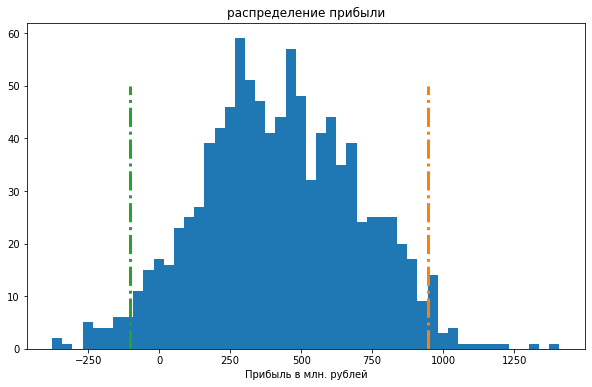

In [22]:
print('1 регион 500 скважин результат:')
print('------------------------------------------')
income_all(predictions_valid, target_valid, BOOTSTRAP_SAMPLE, EXPLORE_COUNT)

2 регион 500 скважин результат:
Средняя выручка: 518.2594936973252
------------------------------------------------------------------
Нижняя граница доверительного интервала: 128.12323143308453, верхняя граница: 953.6129820669079
-------------------------------------------------------------------
Вероятность убытков равна 0.30%


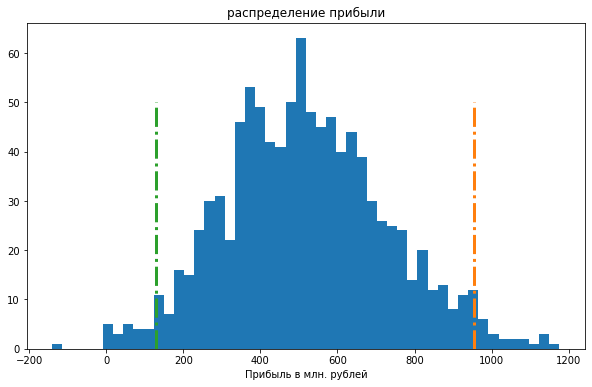

In [23]:
print('2 регион 500 скважин результат:')
income_all(predictions_valid_1, target_valid_1, BOOTSTRAP_SAMPLE, EXPLORE_COUNT)

3 регион 500 скважин результат:
Средняя выручка: 420.19400534405037
------------------------------------------------------------------
Нижняя граница доверительного интервала: -115.85260916001138, верхняя граница: 989.6299398445756
-------------------------------------------------------------------
Вероятность убытков равна 6.20%


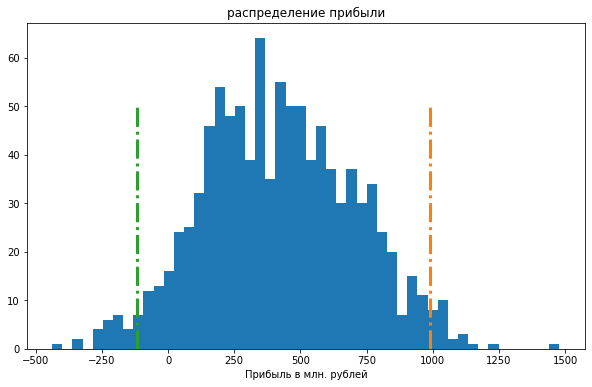

In [24]:
print('3 регион 500 скважин результат:')
income_all(predictions_valid_2, target_valid_2, BOOTSTRAP_SAMPLE, EXPLORE_COUNT)

## вывод

**Прибыль с 200 топовых скважин по предсказанной модели: Итог выбираем первый региона , но когда будем уже проверять на 500 скважинах соответственно результаты у нас меняются.**

* регион 1 - 3320.826 млн. руб.

* регион 2 - 2415.087 млн. руб.

* регион 3 - 2710.350 млн. руб.

**Резултаты на 500 скважинах и в итоге выбираем 2 регион он показал наилучший результат**

*1 Регион*

`1 регион 500 скважин результат:
Средняя выручка: 425.9385269105927
95%-ый доверительный интервал: (408.7322070686989, 443.1448467524865)
Вероятность убытков равна 6.00%`

*2 Регион*

`2 регион 500 скважин результат:
Средняя выручка: 518.2594936973252
95%-ый доверительный интервал: (505.249881576622, 531.2691058180284)
Вероятность убытков равна 0.30%` <--------- вошёл в 2.5%

*3 регион*

`3 регион 500 скважин результат:
Средняя выручка: 420.19400534405037
95%-ый доверительный интервал: (402.52870365036176, 437.859307037739)
Вероятность убытков равна 6.20%`